In [30]:
import importlib
import cv2

import yolo_pose as y
import face_landmark as f

importlib.reload(y)
importlib.reload(f)

<module 'face_landmark' from 'c:\\Users\\Tian_\\Documents\\School\\Meng\\AER 1515\\Project\\face_landmark.py'>

In [21]:
# yolo stuff
model = y.test()

In [33]:
# Access the results
model.to("cpu")
results = model("./datasets/coco8-pose/images/train/000000000077.jpg")  # predict on an image

img = cv2.imread("./datasets/coco8-pose/images/train/000000000077.jpg")
y.draw_pose(img, results)


image 1/1 c:\Users\Tian_\Documents\School\Meng\AER 1515\Project\datasets\coco8-pose\images\train\000000000077.jpg: 480x640 3 persons, 96.4ms
Speed: 1.9ms preprocess, 96.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


array([[[242, 221, 183],
        [242, 221, 183],
        [241, 220, 182],
        ...,
        [ 68, 124, 119],
        [100, 156, 151],
        [157, 213, 208]],

       [[242, 221, 183],
        [242, 221, 183],
        [241, 220, 182],
        ...,
        [ 46, 104,  99],
        [ 66, 124, 119],
        [101, 159, 154]],

       [[243, 222, 184],
        [242, 221, 183],
        [242, 221, 183],
        ...,
        [ 52, 115, 106],
        [ 38, 101,  92],
        [ 27,  90,  81]],

       ...,

       [[208, 220, 222],
        [207, 219, 221],
        [207, 219, 221],
        ...,
        [204, 216, 218],
        [204, 216, 218],
        [204, 216, 218]],

       [[206, 218, 220],
        [206, 218, 220],
        [206, 218, 220],
        ...,
        [203, 215, 217],
        [203, 215, 217],
        [203, 215, 217]],

       [[204, 216, 218],
        [204, 216, 218],
        [204, 216, 218],
        ...,
        [205, 217, 219],
        [205, 217, 219],
        [205, 217, 219]]

In [21]:
# face mesh stuff
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='./face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("./datasets/coco8-pose/images/train/000000000036.jpg")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = f.draw_landmarks_on_image(image.numpy_view(), detection_result)
print(annotated_image.shape)
cv2.imshow("face mesh", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


NormalizedLandmark(x=0.5342509746551514, y=0.40201377868652344, z=-0.027224399149417877, visibility=0.0, presence=0.0)
(640, 481, 3)


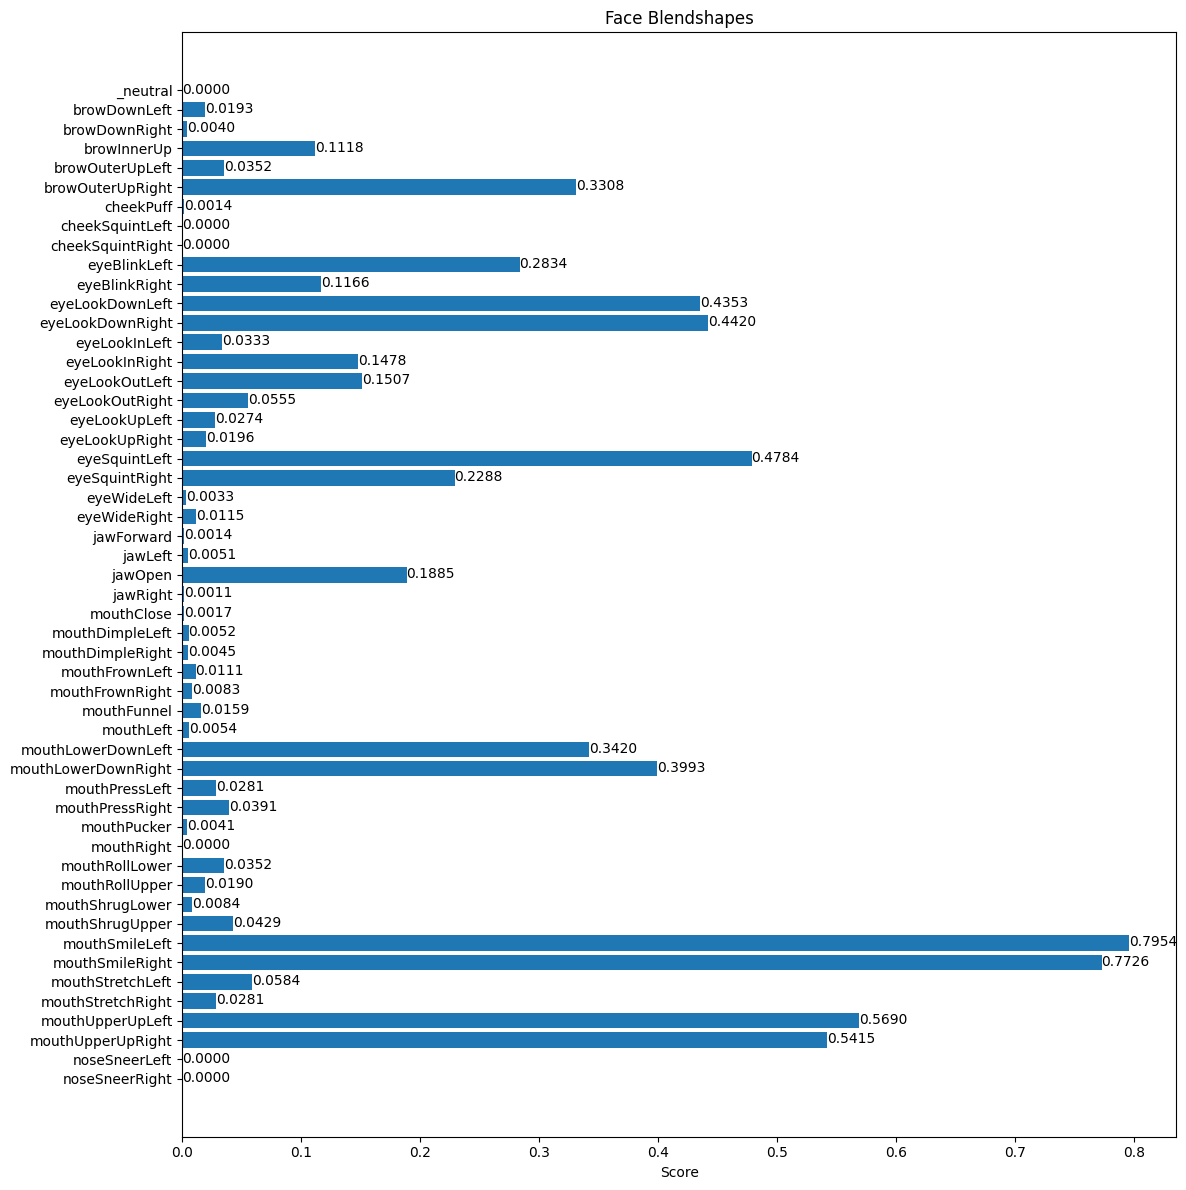

In [13]:
f.plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [29]:
import numpy as np
import visualize_robot_pov_plotly as v
import pickle
import importlib
import matplotlib.pyplot as plt
import torch.nn as nn
import lstm_model as m
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
import torch.utils.data as data
import torch

importlib.reload(v)
importlib.reload(m)
from visualize_robot_pov_plotly import DataPointSet

In [ ]:
def create_sequences(dpt_set_list, seq_length, stride, time_offset_secs = 0, dpt_set_class = True):
    # note the data we had is 5hz
    time_offset_i = time_offset_secs * 5

    X, y = [], []
    for dpt_set in dpt_set_list:
        # combine all dpt arrays in the data_points dict into one array
        if dpt_set_class:
            dpt_array = np.concatenate(list(dpt_set.data_points.values()), axis = 0) # dim x N
        # also accept if we already have a np array of dimension dim x n
        # note dim is 17 x 3 in 3d or 17 x 2 in 2d for yolo pose
        else:
            dpt_array = dpt_set
        
        data_len = dpt_array.shape[1]
        for i in range(0, data_len - seq_length - time_offset_i, stride):
            X.append(dpt_array[:, i:i+seq_length])

            if True in dpt_set.labels[i + time_offset_i:i+ time_offset_i + seq_length]:
                y.append([True])
            else:
                y.append([False])
    
    X = np.array(X)
    X = np.transpose(X, (0, 2, 1))
    y = np.array(y)
    return X, y

# to 0-1 for now, need to extend to saving scaling factors
# assumes format N x seq len x d
def scale_seq(seq):
    N, seq_len, d = seq.shape

    for i in range(0, d):
        seq[:,:,i] = (seq[:,:,i] - seq[:,:,i].min())/(seq[:,:,i].max() - seq[:,:,i].min())
    return seq

# load data and train model
dir = "./datasets/processed/preproc_out.pkl"
with open(dir, "rb") as f:
    robot_trajs, human_trajs = pickle.load(f) # robot traj not trained on, just for reference

X, y = create_sequences(human_trajs, 25, 1, time_offset_secs=5)
data_dim = X.shape[1]

X = scale_seq(X)
n, seq_len, d = X.shape

dataset = data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_dataset, val_dataset = data.random_split(dataset, [0.6, 0.4])
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size=32)

In [9]:
print(y.sum())
print(len(y))
print(torch.version.cuda)
torch.cuda.is_available()

29378
84765
12.8


True

In [10]:
import torch.optim as optim

def get_metrics(y_true, y_pred):
    y_true_in = y_true.detach().numpy().flatten()
    y_pred_in = y_pred.detach().numpy().flatten()

    y_pred_in[y_pred_in > 0.5] = 1
    y_pred_in[y_pred_in < 0.5] = 0

    y_true_in = y_true_in.astype(bool)
    y_pred_in = y_pred_in.astype(bool)

    train_precis = precision_score(y_true_in, y_pred_in, zero_division=0)
    train_recall = recall_score(y_true_in, y_pred_in, zero_division=0)

    tp = np.sum(y_true_in & y_pred_in)
    tn = np.sum(~y_true_in & ~y_pred_in)

    fp = np.sum(y_true_in & ~y_pred_in)
    fn = np.sum(~y_true_in & y_pred_in)

    return train_precis, train_recall, np.array([tp, tn, fp, fn])

# Hyperparameters
epochs = 100
lr = 0.01
batch_size = 32

train_precis = 0
train_recall = 0

val_precis = 0
val_recall = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")
model = m.SimpleLSTM(input_size = d).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Simple training loop
for epoch in range(epochs):
    train_rates = np.array([0,0,0,0])
    val_rates = np.array([0,0,0,0])

    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)

        precis, recall, rates = get_metrics(y_batch.to("cpu"), y_pred.to("cpu"))
        train_precis += precis * x_batch.size(0)
        train_recall += recall * x_batch.size(0)
        train_rates += rates

    train_loss /= len(train_loader.dataset)
    train_precis /= len(train_loader.dataset)
    train_recall /= len(train_loader.dataset)
        
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)

            precis, recall, rates = get_metrics(y_batch.to("cpu"), y_pred.to("cpu"))
            val_precis += precis * x_batch.size(0)
            val_recall += recall * x_batch.size(0)
            val_rates += rates

    val_loss /= len(val_loader.dataset)
    val_precis /= len(val_loader.dataset)
    val_recall /= len(val_loader.dataset)

    if (epoch+1) % 10 == 0 or True:
        print(f"Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, prec: {train_precis:.4f}, rec: {train_recall:.4f}, rates: {train_rates} | val loss: {val_loss:.4f}, prec: {val_precis:.4f}, rec: {val_recall:.4f}, rates: {val_rates}")

training on cuda
Epoch 1/100, train loss: 0.4812, prec: 0.6592, rec: 0.5474, rates: [ 9563 29434  8002  3860] | val loss: 0.4516, prec: 0.8538, rec: 0.4740, rates: [ 5624 21157  6189   936]
Epoch 2/100, train loss: 0.4184, prec: 0.7688, rec: 0.6607, rates: [11607 29416  5958  3878] | val loss: 0.4545, prec: 0.8663, rec: 0.4055, rates: [ 4765 21394  7048   699]
Epoch 3/100, train loss: 0.4021, prec: 0.7821, rec: 0.6762, rates: [11877 29693  5688  3601] | val loss: 0.3931, prec: 0.7626, rec: 0.7291, rates: [ 8587 19421  3226  2672]
Epoch 4/100, train loss: 0.3892, prec: 0.7893, rec: 0.6878, rates: [12084 29868  5481  3426] | val loss: 0.3916, prec: 0.8429, rec: 0.6243, rates: [ 7365 20719  4448  1374]
Epoch 5/100, train loss: 0.3848, prec: 0.7947, rec: 0.6963, rates: [12208 29960  5357  3334] | val loss: 0.3923, prec: 0.7805, rec: 0.6834, rates: [ 8081 19825  3732  2268]
Epoch 6/100, train loss: 0.3779, prec: 0.8063, rec: 0.7009, rates: [12276 30087  5289  3207] | val loss: 0.3623, prec:

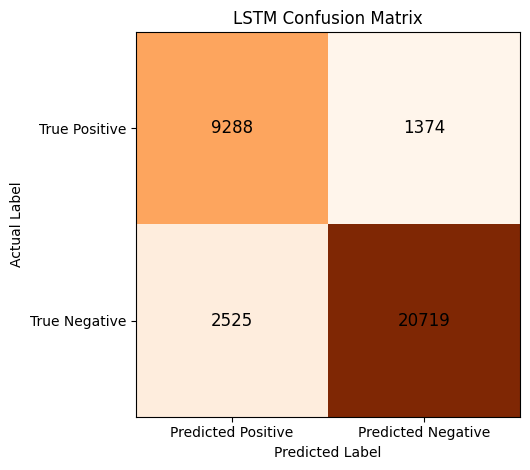

In [17]:

def plot_confusion_matrix(arr):
    """
    Expects arr = [TP, TN, FP, FN]
    Plots confusion matrix using matplotlib.
    """
    TP, TN, FP, FN = arr
    
    matrix = np.array([
        [TP, FN],
        [FP, TN]
    ])

    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap="Oranges")

    # Labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Predicted Positive", "Predicted Negative"])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["True Positive", "True Negative"])

    # Show values inside squares
    for i in range(2):
        for j in range(2):
            ax.text(j, i, matrix[i, j], ha="center", va="center", color="black", fontsize=12)

    # Titles
    ax.set_title("LSTM Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")

    plt.tight_layout()
    plt.show()

arr = [9288, 20719, 2525, 1374]
plot_confusion_matrix(arr)